# [IAPR][iapr]: Lab 2 ‒  Object description


**Group ID:** xx

**Author 1 (sciper):** Alexander Pisarewski (269689)  
**Author 2 (sciper):** Guillaume Champain(xxxxx)   
**Author 3 (sciper):** Adrien (xxxxx)   

**Release date:** 26.03.2021  
**Due date:** 23.04.2021 


## Important notes

The lab assignments are designed to teach practical implementation of the topics presented during class well as preparation for the final project, which is a practical project which ties together the topics of the course. 

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook !** rerun the notebook from scratch `Kernel` > `Restart & Run All`


[iapr]: https://github.com/LTS5/iapr

## 0. Extract relevant data
We first need to extract the `lab-02-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
data_part1 = os.path.join(data_base_path, data_folder, 'part1')
data_part2 = os.path.join(data_base_path, data_folder, 'part2')

tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

---
## Part 1
In the `lab-02-data/part1` folder, you will find 28x28 grey-scale pictures of handwritten "0" and "1".
These digits have been extracted from MNIST dataset (http://yann.lecun.com/exdb/mnist/).

Your goal is to extract, from each of those images, a 2-dimensional feature vector (i.e. 2 features) and to plot them all on a 2D graph.
If you have chosen good features, the vectors of the "0"'s should nicely cluster in one part of the plane and those of the "1"'s in another.

Please try:
1. Fourier Descriptors (15pts). 
    1. Implementation (10 pts).
    2. Showing invariance to rotation, translation and scaling (5 pts).
2. Additional method of your choice (5 pts)


**Note:** for the Fourier descriptors, the u_k signal has to be constructed by following the contour point after point. Some pre-processing (image binarization, possibly some Mathematical Morphology) might be useful.

### 1.1 Data visualization

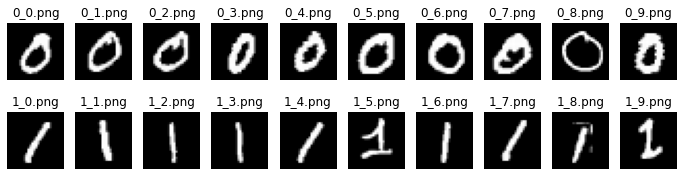

In [2]:
import skimage.io
import matplotlib.pyplot as plt
import cv2
import numpy as np
%matplotlib inline
import itertools
from scipy import special

def load(path, digit='0'):
    digit_path = os.path.join(path, digit)
    digit_names = [nm for nm in os.listdir(digit_path) if '.png' in nm]  # make sure to only load .png
    digit_names.sort()  # sort file names
    ic = skimage.io.imread_collection([os.path.join(digit_path, nm) for nm in digit_names])
    digit_im = skimage.io.concatenate_images(ic)
    return digit_im, digit_names
                        
#  Load zeros and ones
zeros_im, zeros_names = load(data_part1, digit='0')
ones_im, ones_names = load(data_part1, digit='1')


# Plot images
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], ones_im, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

### 1.2 Fourier descriptors (15 pts)

#### A. Implementation

(20, 2, 3)


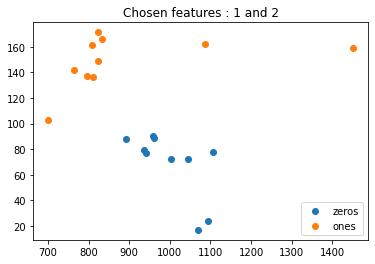

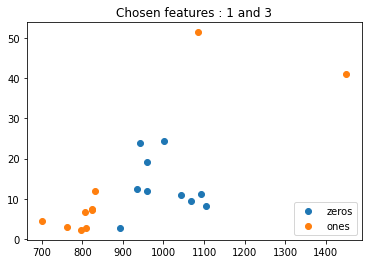

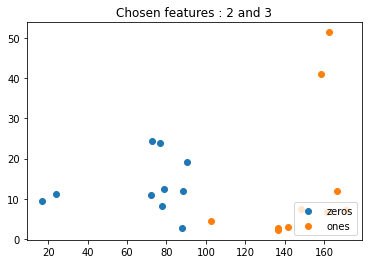

In [3]:


def find_contour(img):

    ret,thresh = cv2.threshold(img,127,255,cv2.THRESH_BINARY)
    contour, hierarchy = cv2.findContours(thresh,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
    contour_array = contour[0][:, 0, :]
    
    return contour_array, thresh

def to_Complex(contour_array):
    
    contour_complex = np.empty(contour_array.shape[:-1], dtype=complex)
    contour_complex.real = contour_array[:, 0]
    contour_complex.imag = contour_array[:, 1]
    fourier = np.fft.fft(contour_complex)

    return fourier

def first_descriptors(fourier,features):
    #features is a vector of the desired features
    res = np.zeros(features.shape)
    count=0
    for ii in features:
        res[count]=np.abs(fourier[ii])
        count+=1
    return res



images = np.concatenate((zeros_im,ones_im))
nb_zeros=zeros_im.shape[0]
nb_ones=ones_im.shape[0]
number_feat=3

poss=int(special.binom((number_feat),2))
descriptors=np.zeros((nb_zeros+nb_ones,2,poss))
print(descriptors.shape)
ii=0
jj=0
for a, b in itertools.combinations(range(number_feat), 2):
    for im in images:
        cont,newimg= find_contour(im)

        contimg=np.zeros_like(im)
        contimg[cont[:,1],cont[:,0]]=255

        ''' Show the original and the contour
        fig, ax = plt.subplots(1, 2, figsize=(12, 7))
        ax[0].imshow(im,cmap='gray')
        ax[1].imshow(contimg, cmap='gray')
        plt.show() '''

        fourier = to_Complex(cont)
        feat=np.array([a,b])
        descriptors[ii,:,jj]=first_descriptors(fourier,feat)

        ii+=1
    ii=0
    jj+=1

    
# Plotting the first 2 fourier descriptors
kk=0

for a, b in itertools.combinations(range(number_feat), 2):
    fig, ax = plt.subplots(1)
    ax.scatter(descriptors[0:nb_zeros,0,kk],descriptors[0:nb_zeros,1,kk],label='zeros')
    ax.scatter(descriptors[nb_zeros:,0,kk],descriptors[nb_zeros:,1,kk],label='ones')
    plt.title('Chosen features : {} and {}'.format(a+1,b+1))
    leg=ax.legend(loc='lower right')
    kk+=1

### B. Invariance to Rotation, Translation and Scaling

In [4]:
#### TRANSLATION SCALING AND ROTATION ####

import random
zeros_im_dst=np.zeros(zeros_im.shape)
ones_im_dst=np.zeros(ones_im.shape)
rows,cols = zeros_im[0,:,:].shape
scale=0.6
rotation=360
trans=4

for i in range(0,len(zeros_im)):
    n1 = random.randint(-trans,trans)
    n2 = random.randint(-trans,trans)
    sc = scale*random.random()+0.5
    rot = rotation*random.random() 
    M_t = np.float32([[1,0,n1],[0,1,n2]])
    M_rot_sc = cv2.getRotationMatrix2D((cols/2,rows/2),rot,sc)
    zeros_im_dst[i,:,:] = cv2.warpAffine(zeros_im[i,:,:],M_t,(cols,rows))   
    zeros_im_dst[i,:,:] = cv2.warpAffine(zeros_im_dst[i,:,:],M_rot_sc,(cols,rows))
    #zeros_im_dst[i,:,:] = zeros_im_dst[i,:,:].astype(np.uint8)

    n3 = random.randint(-trans,trans)
    n4 = random.randint(-trans,trans)
    sc1= scale*random.random()+0.5
    rot1 = rotation*random.random()
    M_t1 = np.float32([[1,0,n3],[0,1,n4]])
    M_rot_sc1 = cv2.getRotationMatrix2D((cols/2,rows/2),rot1,sc1)
    ones_im_dst[i,:,:] = cv2.warpAffine(ones_im[i,:,:],M_t1,(cols,rows))
    ones_im_dst[i,:,:] = cv2.warpAffine(ones_im[i,:,:],M_rot_sc1,(cols,rows))
    #ones_im_dst[i,:,:] = ones_im_dst.astype(np.uint8)
    
    


In [5]:
ones_im_dst = ones_im_dst.astype(np.uint8)
zeros_im_dst = zeros_im_dst.astype(np.uint8)

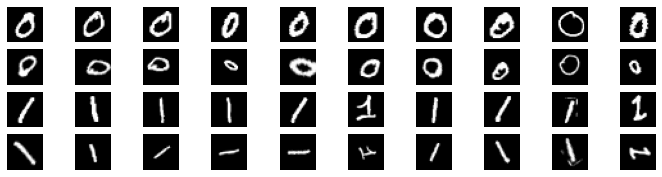

In [6]:
# Plot images
fig, axes = plt.subplots(4, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')

for ax, im, nm in zip(axes[1], zeros_im_dst, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')

for ax, im, nm in zip(axes[2], ones_im, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')

for ax, im, nm in zip(axes[3], ones_im_dst, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')

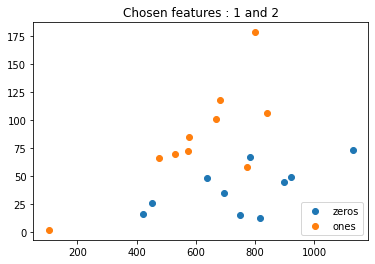

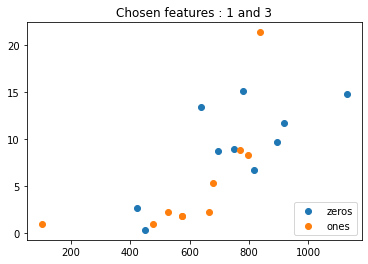

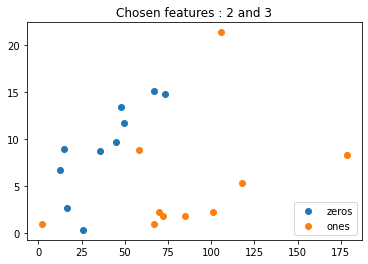

In [7]:
images = np.concatenate((zeros_im_dst,ones_im_dst))
nb_zeros=zeros_im_dst.shape[0]
nb_ones=ones_im_dst.shape[0]
number_feat=3

poss=int(special.binom((number_feat),2))
descriptors=np.zeros((nb_zeros+nb_ones,2,poss))
ii=0
jj=0

for a, b in itertools.combinations(range(number_feat), 2):
    for im in images:
       # figg, axx = plt.subplots(1)
        #axx.imshow(im, cmap='gray')
        
        cont,newimg= find_contour(im)

        contimg=np.zeros_like(im)
        contimg[cont[:,1],cont[:,0]]=255;

        fourier = to_Complex(cont)
        feat=np.array([a,b])
        descriptors[ii,:,jj]=first_descriptors(fourier,feat)

        ii+=1
    ii=0
    jj+=1

    
# Plotting the first 2 fourier descriptors
kk=0
for a, b in itertools.combinations(range(number_feat), 2):
    fig, ax = plt.subplots(1)
    ax.scatter(descriptors[0:nb_zeros,0,kk],descriptors[0:nb_zeros,1,kk],label='zeros')
    ax.scatter(descriptors[nb_zeros:,0,kk],descriptors[nb_zeros:,1,kk],label='ones')
    plt.title('Chosen features : {} and {}'.format(a+1,b+1))
    leg=ax.legend(loc='lower right')
    kk+=1

### 1.3 Additional method (5 pts)

In [8]:
# Add your implementation and discussion

---
## Part 2
The `lab-02-data/part2` folder contains grey-scale pictures of handwritten "2" and "3".
Extract the same feature (typically 2 Fourier descriptors) as in part 1 also on these images and plot them on the same graph as the features of the "0" and "1".
Is it possible to discriminate all these 4 digits with a 2-dimensional feature vector?

### 2.1 Data visualization

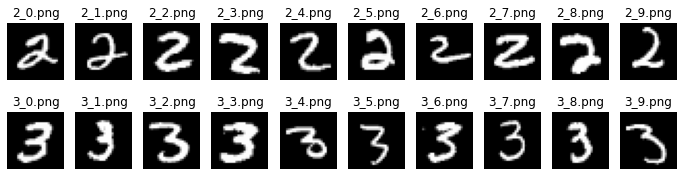

In [9]:
#  Load twos and threes
twos_im, twos_names = load(data_part2, digit='2')
threes_im, threes_names = load(data_part2, digit='3')

# Plot images
fig, axes = plt.subplots(2, len(twos_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], twos_im, twos_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], threes_im, threes_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

### 2.2 Fourier descriptors - 4 digits (10 pts)

(40, 2, 10)


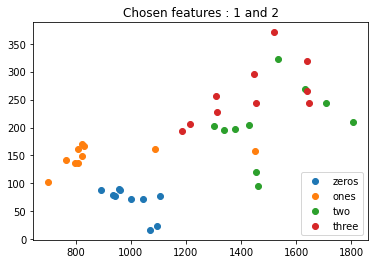

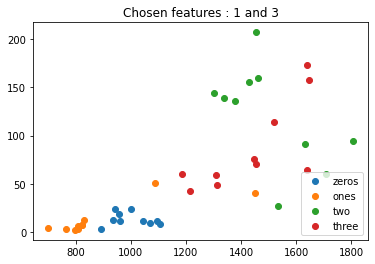

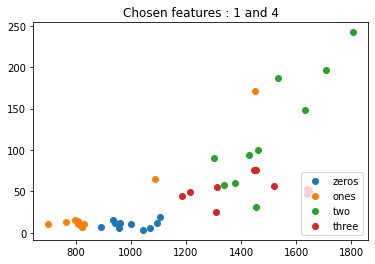

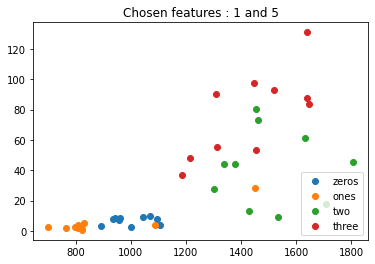

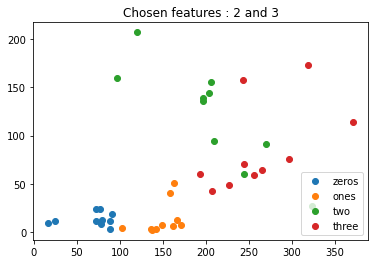

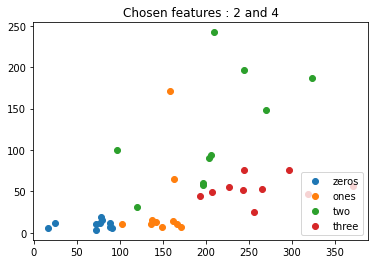

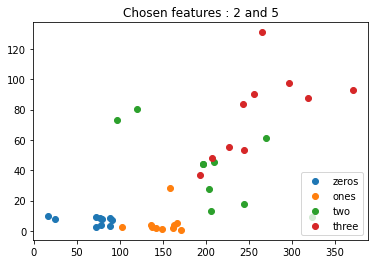

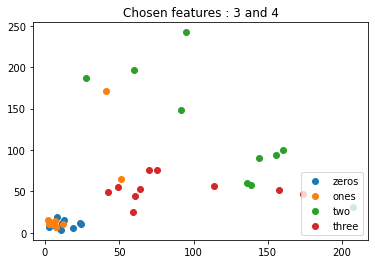

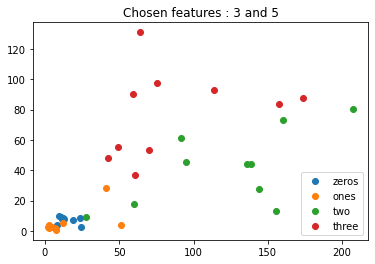

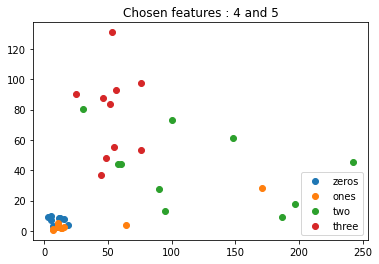

In [10]:
# Add your implementation and discussion

images = np.concatenate((zeros_im,ones_im,twos_im,threes_im))
nb_zeros=zeros_im.shape[0]
nb_ones=ones_im.shape[0]
nb_twos=twos_im.shape[0]
nb_threes=threes_im.shape[0]
number_feat=5

poss=int(special.binom((number_feat),2))
descriptors=np.zeros((nb_zeros+nb_ones+nb_twos+nb_threes,2,poss))
print(descriptors.shape)
ii=0
jj=0
for a, b in itertools.combinations(range(number_feat), 2):
    for im in images:
        cont,newimg= find_contour(im)

        contimg=np.zeros_like(im)
        contimg[cont[:,1],cont[:,0]]=255

        ''' Show the original and the contour
        fig, ax = plt.subplots(1, 2, figsize=(12, 7))
        ax[0].imshow(im,cmap='gray')
        ax[1].imshow(contimg, cmap='gray')
        plt.show()
        '''

        fourier = to_Complex(cont)
        feat=np.array([a,b])
        descriptors[ii,:,jj]=first_descriptors(fourier,feat)

        ii+=1
    ii=0
    jj+=1

    
# Plotting the first 2 fourier descriptors
kk=0

for a, b in itertools.combinations(range(number_feat), 2):
    fig, ax = plt.subplots(1)
    ax.scatter(descriptors[0:nb_zeros,0,kk],descriptors[0:nb_zeros,1,kk],label='zeros')
    ax.scatter(descriptors[nb_zeros:nb_zeros+nb_ones,0,kk],descriptors[nb_zeros:nb_zeros+nb_ones,1,kk],label='ones')
    ax.scatter(descriptors[nb_zeros+nb_ones:nb_zeros+nb_ones+nb_twos,0,kk],descriptors[nb_zeros+nb_ones:nb_zeros+nb_ones+nb_twos,1,kk],label='two')
    ax.scatter(descriptors[nb_zeros+nb_ones+nb_twos:nb_zeros+nb_ones+nb_twos+nb_threes,0,kk],descriptors[nb_zeros+nb_ones+nb_twos:nb_zeros+nb_ones+nb_twos+nb_threes,1,kk],label='three')

    plt.title('Chosen features : {} and {}'.format(a+1,b+1))
    leg=ax.legend(loc='lower right')
    kk+=1